# The Current Controversy
We are now going to apply some of the same techniques to tackle the so-called Current Controversy of the 2013 World Championships.
In those championships in Barcelona, there were anecdotal reports of a very slight, swirling current in the pool. 
So, for example in a 50 meter event, swimmers in lane 8 would be swimming with the current, while those in lane 1 
would be swimming against it. Unfortunately, the pool used in the 2013 World Championships was temporary and 
was deconstructed after the competition. So there is no way of measuring the current after the fact. 
Our goal in this nptebook is to use our statistical thinking skills to find evidence of a current in 
the data from the 2013 World Championships.

The analysis we are ging to perform is based on the followiong publication:

Cornett, A., Brammer, C., & Stager, J. (2015). Current controversy: Analysis of the 2013 FINA world swimming championships. Medicine & Science in Sports & Exercise, 47(3), 649-654.

Before investigating lane bias, it is important to know how a swirling current might affect each lane. It is strongest in the outer lanes, and slowest in the middle. This is akin to swirling a cup of tea. The outsides flow the fastest and the center is not flowing. It is also important to know how swimmers are assigned to lanes. For the finals, the swimmer who was fastest in the semifinal is assigned to lane 4. The next fastest is assigned to lane 5. The next to lane 3, and so on. So, in the absence of current, the swimmers in the center two lanes are expected to be the fastest, but there are typically not major differences among swimmers in the outer lanes. For your first analysis, you will look at the 50 meter events, since the swimmers in those events do not turn around. They only swim with or against the putative current. It stands to reason that in a fair pool, we would see athletes swimming in lanes one through three in the finals winning as many medals as those swimming in lanes six through eight. Remember, the top three finishers in the final of each event get medals, so with four strokes and two genders, there are a total of 24 medals awarded in 50 meter events.

## Data Source
The data is freely available at OMEGA from omegatiming.com

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasql as ps
import dc_stat_think as dcst

In [49]:
pd.set_option('max_columns', None)
df_13 = pd.read_csv (r'2013_FINA.csv',skiprows=4)
df_13.head(5)

,athleteid,lastname,firstname,birthdate,gender,name,code,eventid,heat,lane,points,reactiontime,swimtime,split,cumswimtime,splitdistance,daytime,round,distance,relaycount,stroke,splitswimtime
0,244414,KASHARI,ANXHELA,1996-01-01,F,ALBANIA,ALB,33,4,1,578.0,0.68,28.48,1,28.48,50,1000.0,PRE,50,1,FREE,28.48
1,244417,BORSHI,NOEL,1996-01-01,F,ALBANIA,ALB,1,2,3,591.0,0.73,66.77,1,30.84,50,1000.0,PRE,100,1,FLY,30.84
2,244417,BORSHI,NOEL,1996-01-01,F,ALBANIA,ALB,1,2,3,591.0,0.73,66.77,2,66.77,100,1000.0,PRE,100,1,FLY,35.93
3,244421,ZEKTHI,EVIN,1996-01-01,M,ALBANIA,ALB,12,1,4,607.0,0.70,120.43,1,27.67,50,1047.0,PRE,200,1,FREE,27.67
4,244421,ZEKTHI,EVIN,1996-01-01,M,ALBANIA,ALB,12,1,4,607.0,0.70,120.43,2,58.12,100,1047.0,PRE,200,1,FREE,30.45


In [50]:
df_13['lane'].unique()

array([ 1,  3,  4,  6,  9,  2,  5,  8,  7,  0, -1])

In [51]:
df_13['distance'].unique()

array([  50,  100,  200,  400,  800, 1500])

In [52]:
df_13['splitdistance'].unique()

array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100,
       1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500])

In [53]:
df_13['split'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [54]:
df_13['lane'].unique()

array([ 1,  3,  4,  6,  9,  2,  5,  8,  7,  0, -1])

In [55]:
df_13['heat'].unique()

array([ 4,  2,  1,  8, 10,  3,  5,  6,  9,  7, 11,  0])

# First topic: Anaysis of the improvement of individual swimmers moving from low- to high-numbered lanes.

## Tasks
* Investigate improvement of individual swimmers moving from low- to high-numbered lanes in 50 meter events. We choose 50 meter events because there is no turn-around.

* Compute the size of the effect swimming in low versus high lane number has on speed. 

* Finally, test the hypothesis that on average there is no difference between low- and high-numbered lanes.

## Choosing the metric
A good metric is the fractional improvement of the swim time: ( $t_{a}$ -$t_b$)/$t_a$


## The datasets
 Swim times of all swimmers who swam a 50 m semifinal in a high numbered lane and the final in a low numbered lane, and vice versa.

In [56]:
q="""WITH
sem AS(
    SELECT athleteid,eventid, stroke,lane,swimtime 
    FROM df_13 
    WHERE distance=50 AND round='SEM'
),
fin AS (
    SELECT athleteid,eventid, stroke,lane,swimtime 
    FROM df_13 
    WHERE distance=50 AND round='FIN'
)
SELECT sem.athleteid, sem.stroke as stroke,  
sem.eventid AS sem_eventid, fin.eventid AS fin_eventid, 
sem.lane AS sem_lane, sem.swimtime AS sem_swimtime, 
fin.swimtime AS fin_swimtime, fin.lane AS fin_lane
FROM sem INNER JOIN fin
ON (
    sem.athleteid = fin.athleteid AND 
    sem.stroke=fin.stroke AND 
    (
        (sem.lane IN (0,1,2,3) AND fin.lane IN(5,6,7,8)) 
        OR 
        (sem.lane IN (5,6,7,8) AND fin.lane IN (0,1,2,3))
    )
)
"""
all_df=ps.sqldf(q)
q1="""SELECT  CASE WHEN sem_lane>fin_lane THEN sem_swimtime ELSE fin_swimtime END AS swimtime
FROM all_df"""
swimtime_high_lanes_df=ps.sqldf(q1)
swimtime_high_lanes=swimtime_high_lanes_df.values
swimtime_high_lanes=np.reshape(swimtime_high_lanes,(swimtime_high_lanes.shape[0],))
q2="""SELECT  CASE WHEN sem_lane<fin_lane THEN sem_swimtime ELSE fin_swimtime END AS swimtime
FROM all_df"""
swimtime_low_lanes_df=ps.sqldf(q2)
swimtime_low_lanes=swimtime_low_lanes_df.values
swimtime_low_lanes=np.reshape(swimtime_low_lanes,(swimtime_low_lanes.shape[0],))


## ECDF of improvement from low to high lanes
Now that you have a metric for improvement going from low- to high-numbered lanes, plot an ECDF of this metric. I have put together the swim times of all swimmers who swam a 50 m semifinal in a high numbered lane and the final in a low numbered lane, and vice versa. The swim times are stored in the Numpy arrays swimtime_high_lanes and swimtime_low_lanes. Entry i in the respective arrays are for the same swimmer in the same event.

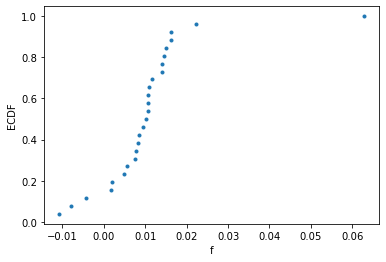

In [57]:
# Compute the fractional improvement of being in high lane: f

f = (swimtime_low_lanes - swimtime_high_lanes) / swimtime_low_lanes

# Make x and y values for ECDF: x, y
x, y =dcst.ecdf(f)

# Plot the ECDFs as dots
_=plt.plot(x,y, marker='.',linestyle='none')

# Label the axes and show the plot
plt.xlabel('f')
plt.ylabel('ECDF')
plt.show()

## Estimation of mean improvement
You will now estimate how big this current effect is. Compute the mean fractional improvement for being in a high-numbered lane versus a low-numbered lane, along with a 95% confidence interval of the mean.

In [58]:
# Compute the mean difference: f_mean
f_mean = np.mean(f)

# Draw 10,000 bootstrap replicates: bs_reps
bs_reps = dcst.draw_bs_reps(f,np.mean,size=10000)

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_reps,[2.5,97.5])

# Print the result
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]""".format(f_mean, *conf_int))


mean frac. diff.: 0.01051
95% conf int of mean frac. diff.: [0.00615, 0.01604]


It looks like swimmers are faster in lanes 5-8.

## How should we test the hypothesis?
* Null hypothesis: the mean fractional improvement going from low to high lane numbers is zero.
* Statistical Test: Subtract the mean of f from f to generate f_shift. Then, take bootstrap replicate of the mean from this f_shift.


In [59]:
# Shift f: f_shift
f_shift = f - f_mean

# Draw 100,000 bootstrap replicates of the mean: bs_reps
bs_reps = dcst.draw_bs_reps(f_shift,np.mean,size=100000)

# Compute and report the p-value
p_val = np.sum(bs_reps>f_mean) / 100000
print('p =', p_val)

p = 0.00028


A p-value of 0.0003 is quite small which is strong evidence against the null hypothesis. this means that the mean fractional improvment is greater than zero.

## Did the 2015 event have this problem?
To address this question, we will perform a similar analysis for the results of the 2015 FINA World Championships. 

### The dataset

In [60]:
pd.set_option('max_columns', None)
df_15 = pd.read_csv (r'2015_FINA.csv',skiprows=4)
#df.head(5)

In [61]:
q="""WITH
sem AS(
    SELECT athleteid,eventid, stroke,lane,swimtime 
    FROM df_15 
    WHERE distance=50 AND round='SEM'
),
fin AS (
    SELECT athleteid,eventid, stroke,lane,swimtime 
    FROM df_15 
    WHERE distance=50 AND round='FIN'
)
SELECT sem.athleteid, sem.stroke as stroke,  
sem.eventid AS sem_eventid, fin.eventid AS fin_eventid, 
sem.lane AS sem_lane, sem.swimtime AS sem_swimtime, 
fin.swimtime AS fin_swimtime, fin.lane AS fin_lane
FROM sem INNER JOIN fin
ON (
    sem.athleteid = fin.athleteid AND 
    sem.stroke=fin.stroke AND 
    (
        (sem.lane IN (0,1,2,3) AND fin.lane IN(5,6,7,8)) 
        OR 
        (sem.lane IN (5,6,7,8) AND fin.lane IN (0,1,2,3))
    )
)
"""
all_df=ps.sqldf(q)
q1="""SELECT  CASE WHEN sem_lane>fin_lane THEN sem_swimtime ELSE fin_swimtime END AS swimtime
FROM all_df"""
swimtime_high_lanes_df=ps.sqldf(q1)
swimtime_high_lanes_15=swimtime_high_lanes_df.values
swimtime_high_lanes_15=np.reshape(swimtime_high_lanes_15,(swimtime_high_lanes_15.shape[0],))
q2="""SELECT  CASE WHEN sem_lane<fin_lane THEN sem_swimtime ELSE fin_swimtime END AS swimtime
FROM all_df"""
swimtime_low_lanes_df=ps.sqldf(q2)
swimtime_low_lanes_15=swimtime_low_lanes_df.values
swimtime_low_lanes_15=np.reshape(swimtime_low_lanes_15,(swimtime_low_lanes_15.shape[0],))

### The hypothesis test

In [62]:
# Compute f and its mean
f = (swimtime_low_lanes_15 - swimtime_high_lanes_15) / swimtime_low_lanes_15
f_mean = np.mean(f)

# Draw 10,000 bootstrap replicates
bs_reps = dcst.draw_bs_reps(f,np.mean,size=10000)

# Compute 95% confidence interval
conf_int = np.percentile(bs_reps,[2.5,97.5])

# Shift f
f_shift = f - f_mean

# Draw 100,000 bootstrap replicates of the mean
bs_reps = dcst.draw_bs_reps(f_shift,np.mean,size=100000)

# Compute the p-value
p_val = np.sum(bs_reps >= f_mean) / 100000

# Print the results
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]
p-value: {3:.5f}""".format(f_mean, *conf_int, p_val))


mean frac. diff.: 0.00079
95% conf int of mean frac. diff.: [-0.00190, 0.00338]
p-value: 0.28267


The confidence interval suggests that the mean is very close to zero.

The high p-value indicates strong evidence in favor of the null hypothesis.

So, both the confidence interval an the p-value suggest that there was no lane bias in 2015.

# Second topic: The zig-zag effect
Now, we will look at how a putative current would effect splits in longer races.

The longest race in the World Championships is the 1500 meter freestyle. The swimmers swim the length of the pool 15 times in each direction. If there is a swirling current, we would expect swimmers in lanes one through three to have fast even splits, when swimming with the current, and slow odd splits, when swimming against it.

In the next set of exercises, we will explore this zigzag effect in depth using all of the 1500 meter splits from the 2013 and 2015 competitions.

## Which splits should we consider?
We should include all splits except the first two and the last two. We should neglect the last two because swimmers stop pacing themselves and "kick" for the final stretch. The first two are different because they involve jumping off the starting blocks and more underwater swimming than others.

## The dataset

In [63]:
q= """WITH 
odd AS (
    SELECT athleteid, lane, AVG(splitswimtime) AS odd_time 
    FROM df_13 
    WHERE distance=1500 AND split NOT IN (1,2,29,30) AND (split%2)=1 
    GROUP BY athleteid, lane
),
even AS (
    SELECT athleteid, lane, AVG(splitswimtime) AS even_time 
    FROM df_13 
    WHERE distance=1500 AND split NOT IN (1,2,29,30) AND (split%2)=0 
    GROUP BY athleteid, lane
),
f_all AS (
    SELECT odd.lane as lane, odd.odd_time AS odd_time, even.even_time AS even_time,
    2.0*(odd_time - even_time)/(odd_time + even_time) AS f
    FROM odd INNER JOIN even ON (odd.lane=even.lane AND odd.athleteid=even.athleteid)
),
average_f AS (
    SELECT  lane, AVG(f) AS f_avg 
    FROM f_all 
    GROUP BY lane

)
SELECT f_avg
FROM average_f
WHERE lane NOT IN (-1,0,9)
"""

f_13=ps.sqldf(q).values
f_13=np.reshape(f_13,(f_13.shape[0],))
#f_13

In [64]:
q= """WITH 
odd AS (
    SELECT athleteid, lane, AVG(splitswimtime) AS odd_time 
    FROM df_15 
    WHERE distance=1500 AND split NOT IN (1,2,29,30) AND (split%2)=1 
    GROUP BY athleteid, lane
),
even AS (
    SELECT athleteid, lane, AVG(splitswimtime) AS even_time 
    FROM df_15 
    WHERE distance=1500 AND split NOT IN (1,2,29,30) AND (split%2)=0 
    GROUP BY athleteid, lane
),
f_all AS (
    SELECT odd.lane as lane, odd.odd_time AS odd_time, even.even_time AS even_time,
    2.0*(odd_time - even_time)/(odd_time + even_time) AS f
    FROM odd INNER JOIN even ON (odd.lane=even.lane AND odd.athleteid=even.athleteid)
),
average_f AS (
    SELECT  lane, AVG(f) AS f_avg 
    FROM f_all 
    GROUP BY lane

)
SELECT f_avg
FROM average_f
WHERE lane NOT IN (-1,0,9)
"""

f_15=ps.sqldf(q).values
f_15=np.reshape(f_15,(f_15.shape[0],))
#f_15

In [65]:
lanes=[1,2,3,4,5,6,7,8]

## EDA: mean differences between odd and even splits
To investigate the differences between odd and even splits, we first need to define a difference metric. 

In previous exercises, we investigated the improvement of moving from a low-numbered lane to a high-numbered lane, defining f = ($t_a$ - $t_b$) / $t_a$. There, the $t_a$ in the denominator served as our reference time for improvement. 

Here, we are considering both improvement and decline in performance depending on the direction of swimming, so we want the reference to be an average. So, we will define the fractional difference as f = 2($t_a$ - $t_b$) / ($t_a$ + $t_b$).

Our task here is to plot the mean fractional difference between odd and even splits versus lane number. 

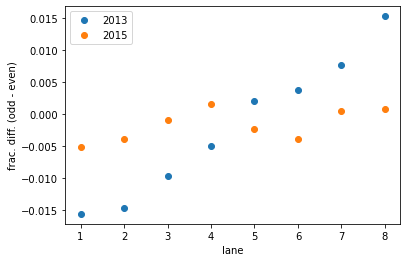

In [66]:
# Plot the the fractional difference for 2013 and 2015
_=plt.plot(lanes,f_13,marker='.',markersize=12,linestyle='none')
_=plt.plot(lanes,f_15,marker='.', markersize=12,linestyle='none')

# Add a legend
plt.legend((2013, 2015))

# Label axes and show plot

plt.xlabel('lane')
plt.ylabel('frac. diff. (odd - even)')
plt.show()


EDA has exposed a strong slope in 2013 compared to 2015!

## How does the current effect depend on lane position?
To quantify the effect of lane number on performance, perform a linear regression on the f_13 versus lanes data. Do a pairs bootstrap calculation to get a 95% confidence interval. Finally, make a plot of the regression. 



slope: 0.00446 per lane
95% conf int: [0.00394, 0.00500] per lane


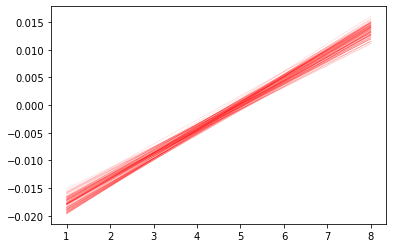

In [67]:
# Compute the slope and intercept of the frac diff/lane curve
slope, intercept = np.polyfit(lanes,f_13,1)

# Compute bootstrap replicates
bs_reps_slope, bs_reps_int = dcst.draw_bs_pairs_linreg(lanes,f_13,size=10000)

# Compute 95% confidence interval of slope
conf_int = np.percentile(bs_reps_slope,[2.5,97.5])

# Print slope and confidence interval
print("""
slope: {0:.5f} per lane
95% conf int: [{1:.5f}, {2:.5f}] per lane""".format(slope, *conf_int))

# x-values for plotting regression lines
x = np.array([1,8])

# Plot 100 bootstrap replicate lines
for i in range(100):
    _ = plt.plot(x, bs_reps_slope[i] * x + bs_reps_int[i], color='red', alpha=0.2, linewidth=0.5)
   
# Update the plot
plt.draw()
plt.show()

The slope is a fractional difference of about 0.4% per lane. This is quite a substantial difference at this elite level of swimming where races can be decided by tiny differences.

## Hypothesis test: can this be by chance?
The EDA and linear regression analysis is pretty conclusive. Nonetheless, we will top off the analysis of the zigzag effect by testing the hypothesis that lane assignment has nothing to do with the mean fractional difference between even and odd lanes using a permutation test. We will use the Pearson correlation coefficient as the test statistic. 

In [68]:
# Compute observed correlation: rho
rho = dcst.pearson_r(lanes,f_13)

# Initialize permutation reps: perm_reps_rho
perm_reps_rho = np.empty(10000)

# Make permutation reps
for i in range(10000):
    # Scramble the lanes array: scrambled_lanes
    scrambled_lanes = np.random.permutation(lanes)
    
    # Compute the Pearson correlation coefficient
    perm_reps_rho[i] = dcst.pearson_r(scrambled_lanes,f_13)
    
# Compute and print p-value
p_val = np.sum(perm_reps_rho >= rho) / 10000
print('p =', p_val)

p = 0.0001


The p-value is very small, as we would expect from the confidence interval of the last item. 

This brings ecidence against that null hypothesis.